# Import necessary libraries

In [1]:
import os 
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression, RidgeClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, accuracy_score 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE 
from xgboost import XGBClassifier 
import shap 
import pickle 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM, Input, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom 
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2, VGG16, VGG19, ResNet50, NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import random

2025-07-20 05:44:27.414461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752990267.614513      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752990267.677568      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
random.seed(10)
print(random.random())

0.5714025946899135


# Load Dataset

In [3]:
N_DAYS = 10
N_MODALITIES = 3
IMG_SIZE = (64, 64)
BASE_DIR = "/kaggle/input/hab-200/dataset_200"
MAX_SAMPLES_PER_CLASS = 200

In [4]:
def load_data(base_dir, max_per_class):
    X, y = [], []
    for label in ["0", "1"]:
        label_dir = os.path.join(base_dir, label)
        samples_loaded = 0
        for sample_folder in sorted(os.listdir(label_dir)):
            if samples_loaded >= max_per_class:
                break
            sample_path = os.path.join(label_dir, sample_folder)
            try:
                day_images = []
                for day in range(1, N_DAYS + 1):
                    modalities = []
                    for mod in range(1, N_MODALITIES + 1):
                        img_path = os.path.join(sample_path, f"{mod}", f"{day:02}.png")
                        img = cv2.imread(img_path)
                        if img is None:
                            raise ValueError(f"Missing image: {img_path}")
                        img = cv2.resize(img, IMG_SIZE)
                        img = img.astype('float32') / 255.0
                        modalities.append(img)
                    modalities_stack = np.concatenate(modalities, axis=-1)
                    day_images.append(modalities_stack)
                sequence = np.stack(day_images, axis=0)
                X.append(sequence)
                y.append(int(label))
                samples_loaded += 1
            except Exception:
                continue
    X = np.array(X)
    y = np.array(y)
    return X[:len(y)], y

In [5]:
X, y = load_data(BASE_DIR, MAX_SAMPLES_PER_CLASS)
print(f"Loaded data: {X.shape}, Labels: {y.shape}")

Loaded data: (400, 10, 64, 64, 9), Labels: (400,)


# Split data

In [6]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, stratify=y_temp, random_state=42, shuffle = True)

In [7]:
X_train.shape, X_test.shape, X_val.shape

((289, 10, 64, 64, 9), (60, 10, 64, 64, 9), (51, 10, 64, 64, 9))

# Training traidtional models

In [8]:
X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

In [9]:
models = {} 

def accuracy_metrics(y_test, y_pred, name): 
    print(f"Accuracy - {name} : {np.round(accuracy_score(y_test, preds), 2)}") 
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred)) 
    cm = confusion_matrix(y_test, y_pred) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic']) 
    disp.plot(cmap='Purples') 
    plt.title(f"Confusion Matrix - {name}") 
    plt.show() 

Accuracy - Logistic Regression : 0.92
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



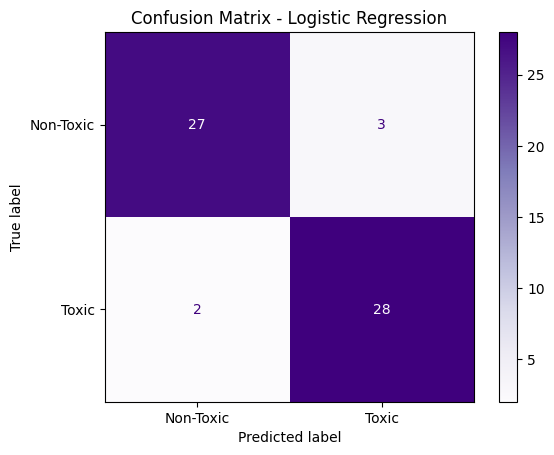

In [10]:
model_lr = LogisticRegression(max_iter=2000)
model_lr.fit(X_train_flat, y_train)
preds = model_lr.predict(X_test_flat)
accuracy_metrics(y_test, preds, 'Logistic Regression')
models['Logistic Regression'] = np.round(accuracy_score(y_test, preds), 2)

Accuracy - Ridge Classifier : 0.9
Ridge Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



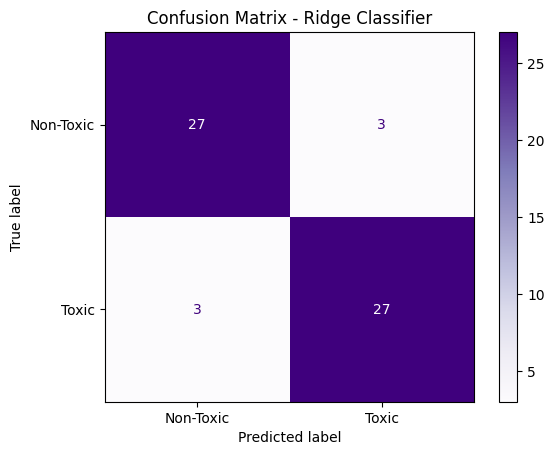

In [11]:
model_ridge = RidgeClassifier()
model_ridge.fit(X_train_flat, y_train)
preds = model_ridge.predict(X_test_flat)
accuracy_metrics(y_test, preds, 'Ridge Classifier')
models['Ridge Classifier'] = np.round(accuracy_score(y_test, preds), 2)

Accuracy - XGB Classifier : 0.85
XGB Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.83      0.85        30
           1       0.84      0.87      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



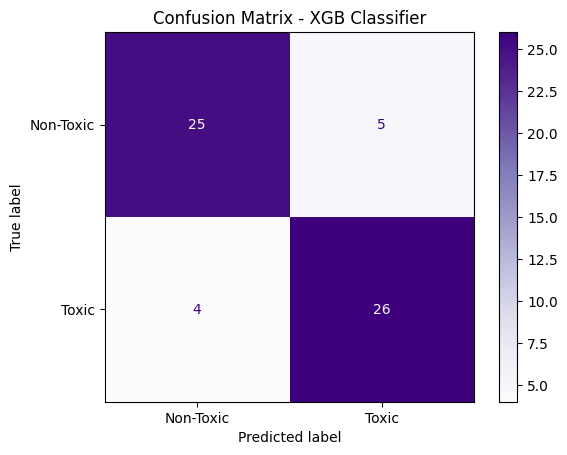

In [12]:
model_xgb = XGBClassifier() 
model_xgb.fit(X_train_flat, y_train) 
preds = model_xgb.predict(X_test_flat) 
accuracy_metrics(y_test, preds, 'XGB Classifier') 
models['XGB Classifier'] = np.round(accuracy_score(y_test, preds) , 2)

Accuracy - DT Classifier : 0.85
DT Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.86      0.83      0.85        30

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



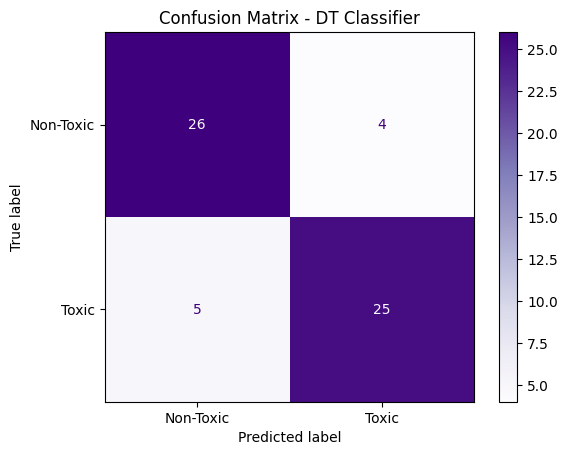

In [13]:
model_dt = DecisionTreeClassifier() 
model_dt.fit(X_train_flat, y_train) 
preds = model_dt.predict(X_test_flat) 
accuracy_metrics(y_test, preds, 'DT Classifier') 
models['DT Classifier'] = np.round(accuracy_score(y_test, preds), 2)

Accuracy - RF Classifier : 0.88
RF Classifier Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89        30
           1       0.90      0.87      0.88        30

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60



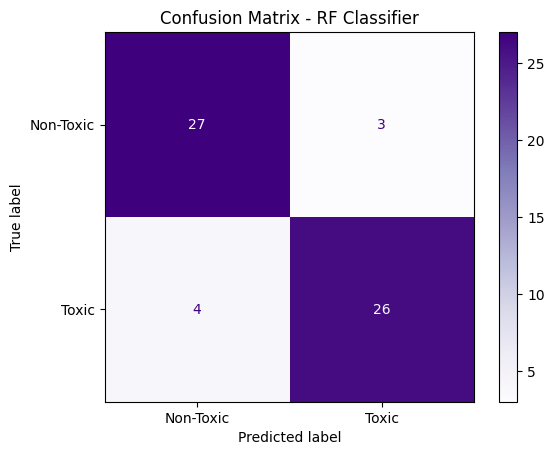

In [14]:
model_rf = RandomForestClassifier() 
model_rf.fit(X_train_flat, y_train) 
preds = model_rf.predict(X_test_flat) 
accuracy_metrics(y_test, preds, 'RF Classifier') 
models['RF Classifier'] = np.round(accuracy_score(y_test, preds), 2)

In [15]:
with open('model_lr.pkl', 'wb') as file: 
    pickle.dump(model_lr, file) 
with open('model_ridge.pkl', 'wb') as file: 
    pickle.dump(model_ridge, file) 
with open('model_xgb.pkl', 'wb') as file: 
    pickle.dump(model_xgb, file) 
with open('model_dt.pkl', 'wb') as file: 
    pickle.dump(model_dt, file) 
with open('model_rf.pkl', 'wb') as file: 
    pickle.dump(model_rf, file) 

# Training Neural Networks

In [16]:
# delete the unnecessary variables that wont be used after this cell block 
del X, y, X_temp, y_temp, X_train_flat, X_test_flat, model_lr, model_ridge, model_xgb, model_dt, model_rf 

print("Unnecessary variables deleted.") 

Unnecessary variables deleted.


In [17]:
from tensorflow.keras.utils import to_categorical 
Y_train = to_categorical(y_train) 
Y_test = to_categorical(y_test) 
Y_val = to_categorical(y_val) 

In [18]:
model_habnet_sigmoid = Sequential([ 
    Input(shape=(N_DAYS, *IMG_SIZE, N_MODALITIES * 3)), 
    TimeDistributed(RandomFlip("horizontal_and_vertical")), 
    TimeDistributed(RandomRotation(0.2)), 
    TimeDistributed(RandomZoom(0.1)), 
    TimeDistributed(Conv2D(16, (3, 3), activation='relu')), 
    TimeDistributed(MaxPooling2D((2, 2))), 
    TimeDistributed(Conv2D(32, (3, 3), activation='relu')), 
    TimeDistributed(MaxPooling2D((2, 2))), 
    TimeDistributed(Flatten()), 
    LSTM(64), 
    Dropout(0.5), 
    Dense(1, activation='sigmoid') 
]) 

model_habnet_sigmoid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 
model_habnet_sigmoid.summary() 

I0000 00:00:1752990657.885535      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752990657.886256      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 62, 62, 16) │         1,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 29, 29, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 6272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │     1,622,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,628,289 (6.21 MB)

 Trainable params: 1,628,289 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model_habnet_sigmoid.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32) 

Epoch 1/20


I0000 00:00:1752990677.773181     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 296ms/step - accuracy: 0.5696 - loss: 0.6191 - val_accuracy: 0.8627 - val_loss: 0.3269
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8548 - loss: 0.3721 - val_accuracy: 0.8824 - val_loss: 0.2544
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8736 - loss: 0.2930 - val_accuracy: 0.8627 - val_loss: 0.3039
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.8784 - loss: 0.3140 - val_accuracy: 0.9020 - val_loss: 0.2186
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9114 - loss: 0.2420 - val_accuracy: 0.9020 - val_loss: 0.2016
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8834 - loss: 0.3080 - val_accuracy: 0.9216 - val_loss: 0.1839
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8908 - loss: 0.3061 - val_accuracy: 0.9020 - val_loss: 0.2250
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.8973 - loss: 0.2669 - val_accuracy: 0.9020 - val_loss: 

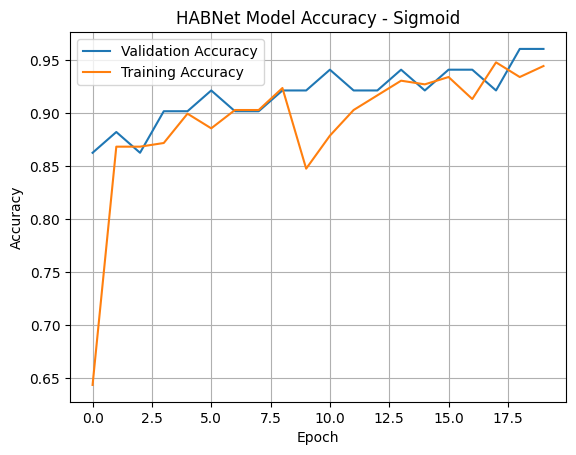

In [20]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
plt.plot(history.history['accuracy'], label='Training Accuracy') 
plt.title('HABNet Model Accuracy - Sigmoid') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.grid(True) 
plt.show() 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  
Accuracy - HABNet Model - Sigmoid : 0.88
HABNet Model - Sigmoid Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        30
           1       0.87      0.87      0.87        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



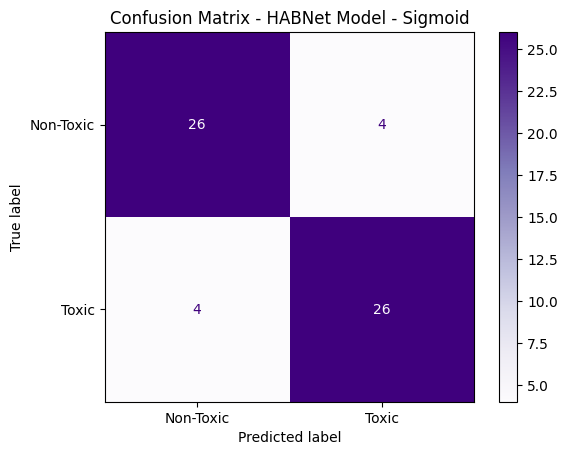

In [21]:
y_pred_habnet = (model_habnet_sigmoid.predict(X_test) > 0.5).astype("int32").flatten() 
accuracy_metrics(y_test, y_pred_habnet, 'HABNet Model - Sigmoid') 
models['HABnet Sigmoid'] = np.round(accuracy_score(y_test, y_pred_habnet), 2)

In [22]:
model_habnet_sigmoid.save('model_habnet_sigmoid.h5') 

In [23]:
model_habnet_softmax = Sequential([ 
    Input(shape=(N_DAYS, *IMG_SIZE, N_MODALITIES * 3)), 
    TimeDistributed(RandomFlip("horizontal_and_vertical")), 
    TimeDistributed(RandomRotation(0.2)), 
    TimeDistributed(RandomZoom(0.1)), 
    TimeDistributed(Conv2D(16, (3, 3), activation='relu')), 
    TimeDistributed(MaxPooling2D((2, 2))), 
    TimeDistributed(Conv2D(32, (3, 3), activation='relu')), 
    TimeDistributed(MaxPooling2D((2, 2))), 
    TimeDistributed(Flatten()), 
    LSTM(64), 
    Dropout(0.5), 
    Dense(64, activation='relu'), 
    Dense(2, activation='softmax') 
]) 

model_habnet_softmax.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model_habnet_softmax.summary() 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_8              │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 64, 64, 9)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 62, 62, 16) │         1,312 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 10, 31, 31, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 10, 29, 29, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 10, 14, 14, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 10, 6272)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │     1,622,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,632,514 (6.23 MB)

 Trainable params: 1,632,514 (6.23 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model_habnet_softmax.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=32) 

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.6428 - loss: 0.6485 - val_accuracy: 0.8627 - val_loss: 0.3887
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8459 - loss: 0.4522 - val_accuracy: 0.9020 - val_loss: 0.3135
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8395 - loss: 0.3948 - val_accuracy: 0.8824 - val_loss: 0.2752
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.6795 - loss: 0.7406 - val_accuracy: 0.9412 - val_loss: 0.3603
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7675 - loss: 0.5065 - val_accuracy: 0.8824 - val_loss: 0.3729
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.8635 - loss: 0.4110 - val_accuracy: 0.9216 - val_loss: 0.2987
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8707 - loss: 0.3871 - val_accuracy: 0.9020 - val_loss: 0.2718
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8298 - loss: 0.4039 - val_accuracy: 0.9216 -

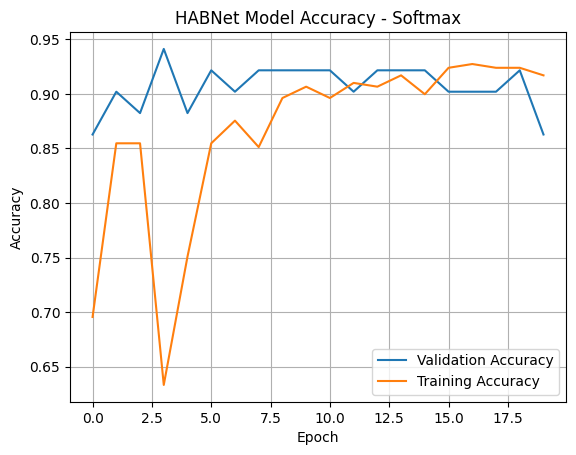

In [25]:
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
plt.plot(history.history['accuracy'], label='Training Accuracy') 
plt.title('HABNet Model Accuracy - Softmax') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy') 
plt.legend() 
plt.grid(True) 
plt.show() 

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step  
Accuracy - HABNet Model - Softmax : 0.88
HABNet Model - Softmax Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



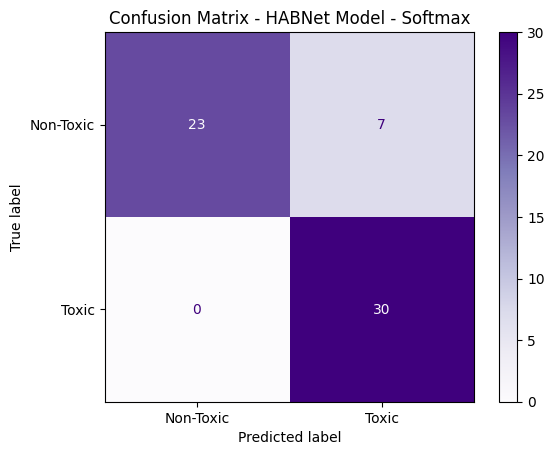

In [26]:
y_pred_habnet = np.argmax(model_habnet_softmax.predict(X_test), axis=1) 
accuracy_metrics(y_test, y_pred_habnet, 'HABNet Model - Softmax') 
models['HABnet Softmax'] = np.round(accuracy_score(y_test, y_pred_habnet), 2)

In [27]:
model_habnet_softmax.save('model_habnet_softmax.h5') 

# Predition on unseen 400 datacubes

In [28]:
test_X, test_y = load_data('/kaggle/input/test-hab-200/Test_HAB_200', 200)
test_X.shape, test_y.shape

((400, 10, 64, 64, 9), (400,))

In [29]:
model_habnet = load_model('/kaggle/working/model_habnet_sigmoid.h5')
y_pred_habnet = (model_habnet.predict(test_X) > 0.5).astype("int32").flatten() 

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


Accuracy : 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74       200
           1       0.78      0.59      0.67       200

    accuracy                           0.71       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.72      0.71      0.71       400



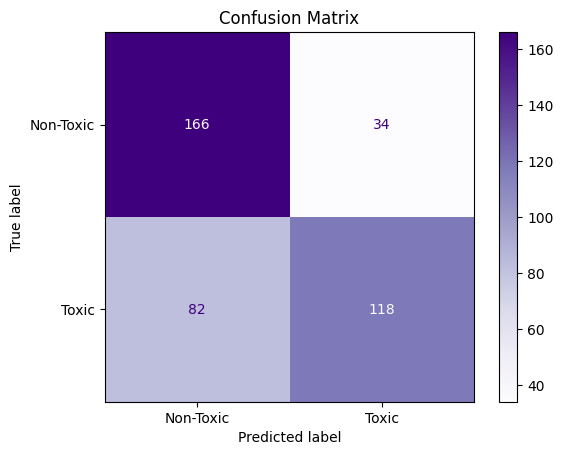

In [30]:
print(f"Accuracy : {np.round(accuracy_score(test_y, y_pred_habnet), 2)}") 
print(f"Classification Report:\n", classification_report(test_y, y_pred_habnet)) 
cm = confusion_matrix(test_y, y_pred_habnet) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic']) 
disp.plot(cmap='Purples') 
plt.title(f"Confusion Matrix") 
plt.show() 

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step
Accuracy : 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.66      0.75       200
           1       0.73      0.91      0.81       200

    accuracy                           0.78       400
   macro avg       0.80      0.78      0.78       400
weighted avg       0.80      0.78      0.78       400



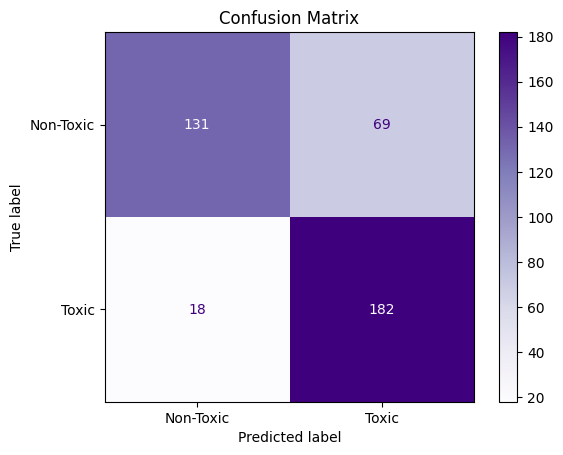

In [31]:
model_habnet = load_model('/kaggle/working/model_habnet_softmax.h5')

y_pred_habnet = np.argmax(model_habnet.predict(test_X), axis = 1) 
print(f"Accuracy : {np.round(accuracy_score(test_y, y_pred_habnet), 2)}") 
print(f"Classification Report:\n", classification_report(test_y, y_pred_habnet)) 
cm = confusion_matrix(test_y, y_pred_habnet) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic']) 
disp.plot(cmap='Purples') 
plt.title(f"Confusion Matrix") 
plt.show() 

Accuracy : 0.72
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.81      0.74       200
           1       0.77      0.61      0.68       200

    accuracy                           0.71       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.72      0.71      0.71       400



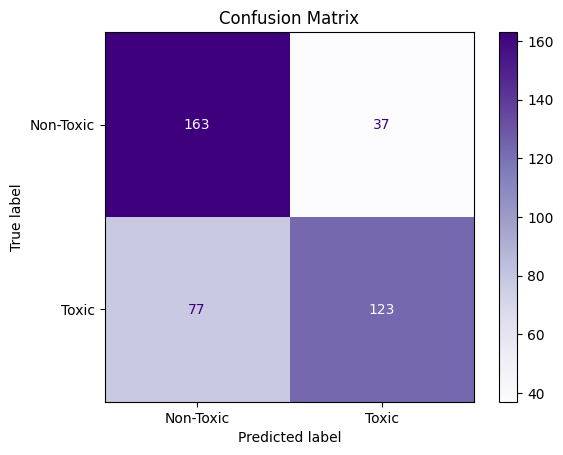

In [32]:
model = open('/kaggle/working/model_lr.pkl','rb')
traditional_model = pickle.load(model)
test_X_flat = test_X.reshape(len(test_X), -1)
preds = traditional_model.predict(test_X_flat)
print(f"Accuracy : {np.round(accuracy_score(test_y, preds), 2)}") 
print(f"Classification Report:\n", classification_report(test_y, preds)) 
cm = confusion_matrix(test_y, preds) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic']) 
disp.plot(cmap='Purples') 
plt.title(f"Confusion Matrix") 
plt.show() 

# Prediction for single datacube

In [33]:
# load the procesed datacube images 

n_days = 10
n_modalities = 3
img_size = (64,64)
test_path = '/kaggle/input/test-hab-200/Test_HAB_200/1/habnet_datacube_20161003_27.1233_-82.4712_128000'
day_images = []
for day in range(1, n_days + 1):
    modalities = []
    for mod in range(1, n_modalities + 1):
        img_path = os.path.join(test_path, f"{mod}", f"{day:02}.png")
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Missing image: {img_path}")
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        modalities.append(img)
        # print(day, mod)
        modalities_stack = np.concatenate(modalities, axis=-1)
    day_images.append(modalities_stack)
sequence = np.stack(day_images, axis=0)
x = np.array(sequence)

x.shape

(10, 64, 64, 9)

In [34]:
# for label
int(model_habnet_sigmoid(np.expand_dims(x, axis=0)).numpy().squeeze() > 0.5)

1

In [35]:
# for probabilitiy of both labels
model_habnet_softmax(np.expand_dims(x, axis=0)).numpy().squeeze()

# to get label directly instead of probabilities
# np.argmax(model_habnet_softmax(np.expand_dims(x, axis=0)), axis = 1)[0]

array([0.00657587, 0.99342406], dtype=float32)

In [36]:
model = open('/kaggle/working/model_lr.pkl','rb')
traditional_model = pickle.load(model)

In [37]:
x = np.expand_dims(x, axis=0)
x_flat = x.reshape(len(x), -1)
x_flat.shape

(1, 368640)

In [38]:
traditional_model.predict(x_flat)[0]

1

# Pretrained models

In [39]:
del X_train, X_val, X_test, test_X, y_train, y_test, y_val, Y_train, Y_test, Y_val

In [40]:
N_DAYS = 10
N_MODALITIES = 3
IMG_SIZE = (224, 224)
BASE_DIR = "/kaggle/input/hab-200/dataset_200"
MAX_SAMPLES_PER_CLASS = 200

In [41]:
X, y = load_data(BASE_DIR, MAX_SAMPLES_PER_CLASS)
print(f"Loaded data: {X.shape}, Labels: {y.shape}")
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42, shuffle = True)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, stratify=y_temp, random_state=42, shuffle = True)

Loaded data: (400, 10, 224, 224, 9), Labels: (400,)


In [42]:
del X_temp, y_temp

In [43]:
train_aug = ImageDataGenerator(horizontal_flip=True, rotation_range=15, zoom_range=0.1) 
val_aug = ImageDataGenerator() 

In [44]:
X_train_rgb = X_train[:, -1, :, :, :3] 
X_val_rgb = X_val[:, -1, :, :, :3] 
X_test_rgb = X_test[:, -1, :, :, :3] 
y_train_cat = to_categorical(y_train) 
y_val_cat = to_categorical(y_val) 
y_test_cat = to_categorical(y_test) 

In [45]:
train_gen = train_aug.flow(X_train_rgb, y_train_cat, batch_size=16) 
val_gen = val_aug.flow(X_val_rgb, y_val_cat, batch_size=16) 

In [46]:
def train_pretrained_model(base_model_fn, name):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_gen, validation_data=val_gen, epochs=20, batch_size=32)
    
    y_pred_dl = model.predict(X_test_rgb)
    y_pred_dl_bin = np.argmax(y_pred_dl, axis=1)
    y_test_dl_bin = np.argmax(y_test_cat, axis=1)
    print(f"{name} Classification Report:\n", classification_report(y_test_dl_bin, y_pred_dl_bin))
    cm = confusion_matrix(y_test_dl_bin, y_pred_dl_bin)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Toxic', 'Toxic']).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
    model.save(f'habnet_{name}.h5')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
    plt.plot(history.history['accuracy'], label='Training Accuracy') 
    plt.title('HABNet Model Accuracy - Softmax') 
    plt.xlabel('Epoch') 
    plt.ylabel('Accuracy') 
    plt.legend() 
    plt.grid(True) 
    plt.show() 
    return model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


Epoch 1/20


I0000 00:00:1752990848.771861     100 service.cc:148] XLA service 0x7a0df025a800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752990848.772505     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752990848.772529     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/19 ━━━━━━━━━━━━━━━━━━━━ 8:02 27s/step - accuracy: 0.5625 - loss: 0.6855

I0000 00:00:1752990858.984220     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.4928 - loss: 0.7193 - val_accuracy: 0.4902 - val_loss: 0.8542
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.4611 - loss: 0.7861 - val_accuracy: 0.4902 - val_loss: 0.7423
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.5592 - loss: 0.6967 - val_accuracy: 0.5098 - val_loss: 0.6963
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.4041 - loss: 0.7336 - val_accuracy: 0.5098 - val_loss: 0.6963
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5348 - loss: 0.7034 - val_accuracy: 0.4902 - val_loss: 0.7660
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.4354 - loss: 0.7552 - val_accuracy: 0.4902 - val_loss: 0.7072
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.5242 - loss: 0.6963 - val_accuracy: 0.5098 - val_loss: 0.7102
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.4976 - loss: 0.7111 - val_accuracy: 0.4902 - val_lo

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


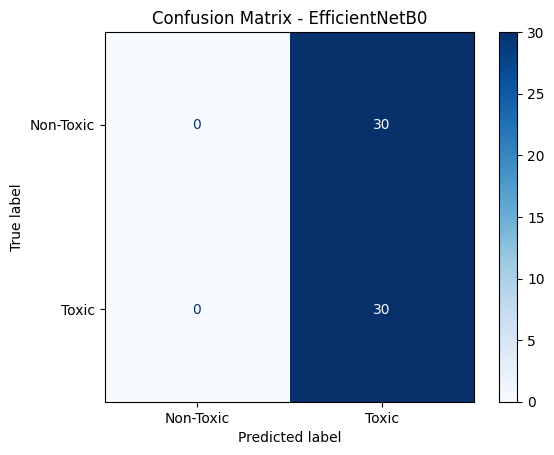

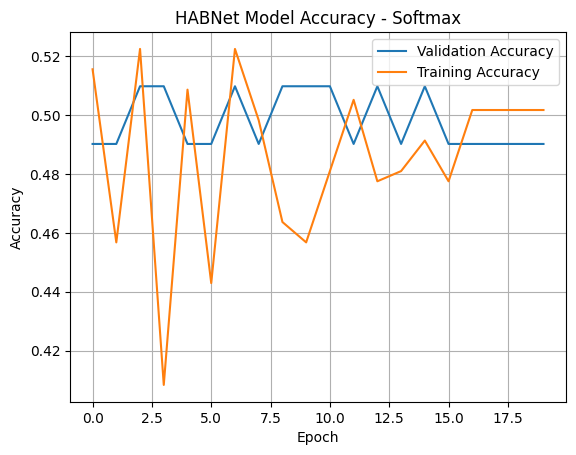

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [47]:
model_effnet = train_pretrained_model(EfficientNetB0, "EfficientNetB0")
preds = np.argmax(model_effnet.predict(X_test_rgb), axis = 1)
models['EfficientNet'] = np.round(accuracy_score(y_test, preds), 2)
del model_effnet

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 614ms/step - accuracy: 0.6056 - loss: 0.8948 - val_accuracy: 0.7255 - val_loss: 0.4796
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7100 - loss: 0.5360 - val_accuracy: 0.7451 - val_loss: 0.4953
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.6908 - loss: 0.5863 - val_accuracy: 0.7647 - val_loss: 0.5077
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.7021 - loss: 0.5477 - val_accuracy: 0.7647 - val_loss: 0.4104
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.7278 - loss: 0.4762 - val_accuracy: 0.7843 - val_loss: 0.3870
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7634 - loss: 0.4356 - val_accuracy: 0.7647 - val_loss: 0.3878
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.7938 - loss: 0.3829 - val_accuracy: 0.7843 - val_loss: 0.3634
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - 

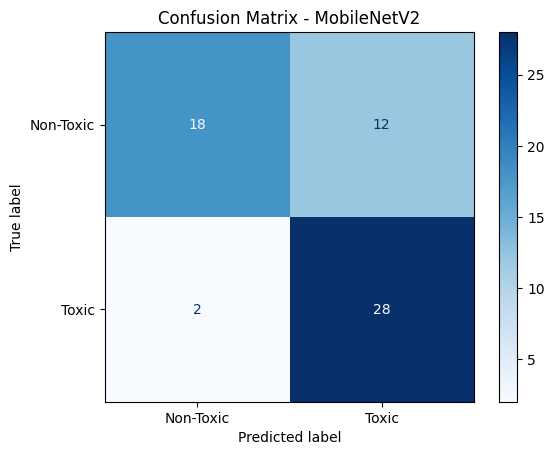

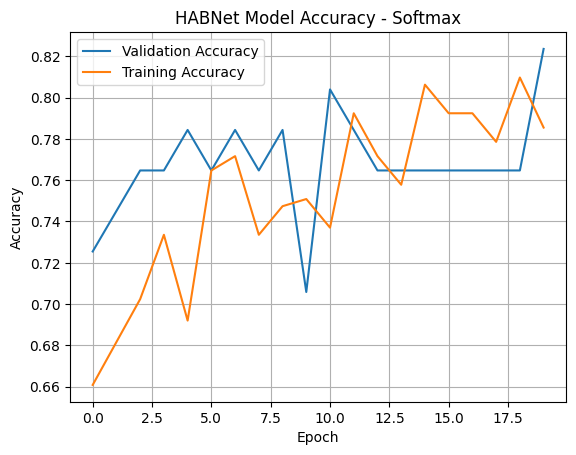

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [48]:
model_mobnet = train_pretrained_model(MobileNetV2, "MobileNetV2")
preds = np.argmax(model_mobnet.predict(X_test_rgb), axis = 1)
models['MobileNet'] = np.round(accuracy_score(y_test, preds), 2)
del model_mobnet

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.5819 - loss: 0.6867 - val_accuracy: 0.6471 - val_loss: 0.6161
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.6283 - loss: 0.6345 - val_accuracy: 0.6471 - val_loss: 0.5891
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6436 - loss: 0.6014 - val_accuracy: 0.7059 - val_loss: 0.5924
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.6980 - loss: 0.5973 - val_accuracy: 0.7059 - val_loss: 0.5714
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7191 - loss: 0.6010 - val_accuracy: 0.6667 - val_loss: 0.5769
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - accuracy: 0.6753 - loss: 0.5878 - val_accuracy: 0.7059 - val_loss: 0.5648
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.6848 - loss: 0.5880 - val_accuracy: 0.6863 - val_loss: 0.5617
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step 

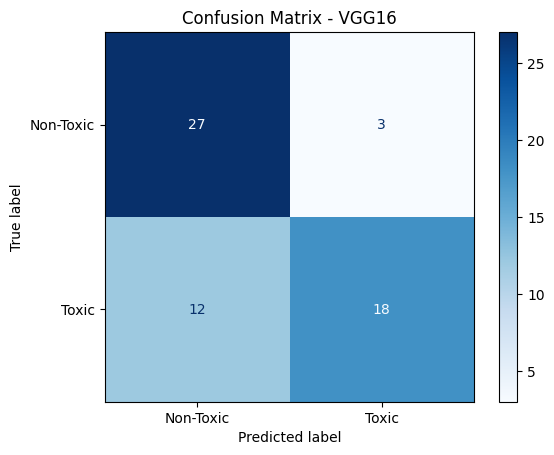

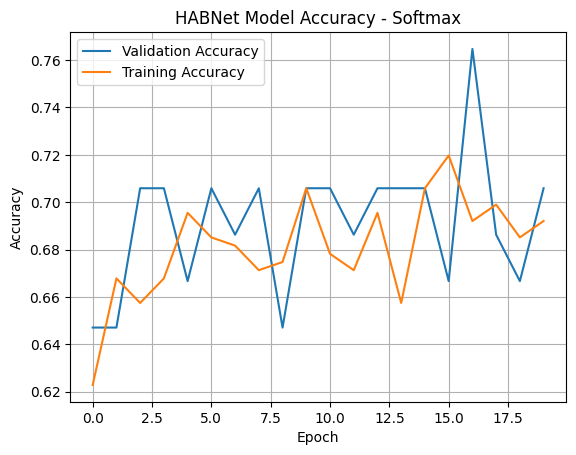

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


In [49]:
model_vgg16 = train_pretrained_model(VGG16, "VGG16")
preds = np.argmax(model_vgg16.predict(X_test_rgb), axis = 1)
models['VGGG16'] = np.round(accuracy_score(y_test, preds), 2)
del model_vgg16

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step - accuracy: 0.4913 - loss: 0.8011 - val_accuracy: 0.4902 - val_loss: 0.6881
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.5465 - loss: 0.6761 - val_accuracy: 0.6471 - val_loss: 0.6208
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.5795 - loss: 0.6317 - val_accuracy: 0.6471 - val_loss: 0.6084
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6080 - loss: 0.6314 - val_accuracy: 0.7451 - val_loss: 0.6218
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.6306 - loss: 0.6503 - val_accuracy: 0.7255 - val_loss: 0.5979
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6702 - loss: 0.6223 - val_accuracy: 0.6078 - val_loss: 0.6142
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.5982 - loss: 0.6313 - val_accuracy: 0.7451 - val_loss: 0.5963
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.6689 - loss: 0.6272 - val_accuracy: 0.

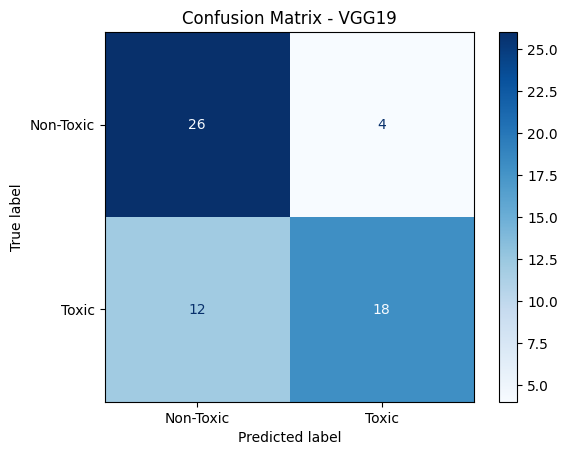

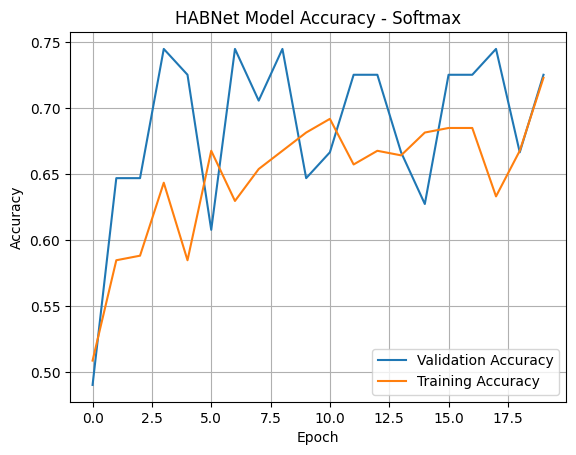

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


In [51]:
model_vgg19 = train_pretrained_model(VGG19, "VGG19")
preds = np.argmax(model_vgg19.predict(X_test_rgb), axis = 1)
models['VGG19'] = np.round(accuracy_score(y_test, preds), 2)
del model_vgg19

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 789ms/step - accuracy: 0.5511 - loss: 0.7029 - val_accuracy: 0.4902 - val_loss: 0.6915
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.4805 - loss: 0.6994 - val_accuracy: 0.4902 - val_loss: 0.6927
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.5376 - loss: 0.7054 - val_accuracy: 0.5098 - val_loss: 0.7679
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.3993 - loss: 0.8241 - val_accuracy: 0.5098 - val_loss: 0.7416
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.4978 - loss: 0.7286 - val_accuracy: 0.4902 - val_loss: 0.6865
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.5258 - loss: 0.7125 - val_accuracy: 0.4902 - val_loss: 0.6741
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - accuracy: 0.5302 - loss: 0.6860 - val_accuracy: 0.7255 - val_loss: 0.6579
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step 

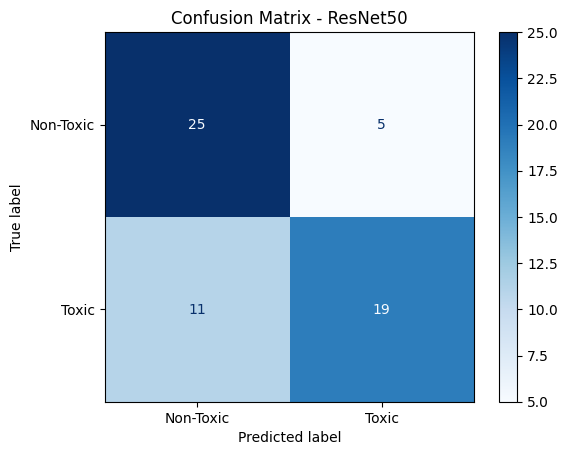

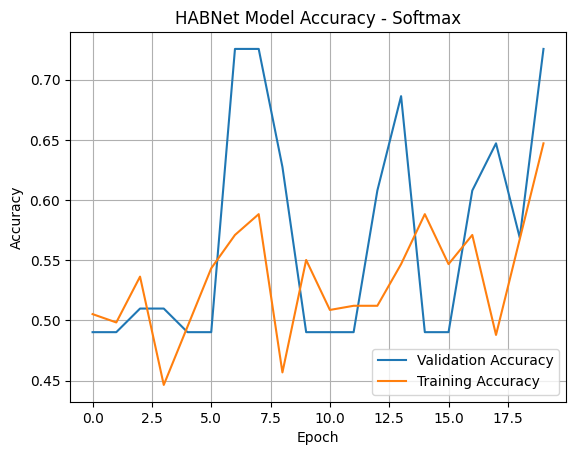

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


In [52]:
model_resnet = train_pretrained_model(ResNet50, "ResNet50")
preds = np.argmax(model_resnet.predict(X_test_rgb), axis = 1)
models['ResNet'] = np.round(accuracy_score(y_test, preds), 2)
del model_resnet

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


E0000 00:00:1752991553.607058     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752991553.755631     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/19 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.6117 - loss: 0.6414 - val_accuracy: 0.6863 - val_loss: 0.5427
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7441 - loss: 0.5487 - val_accuracy: 0.6863 - val_loss: 0.5153
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6846 - loss: 0.6241 - val_accuracy: 0.6471 - val_loss: 0.5727
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.6899 - loss: 0.5468 - val_accuracy: 0.6471 - val_loss: 0.5728
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.7340 - loss: 0.5003 - val_accuracy: 0.7451 - val_loss: 0.4775
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7737 - loss: 0.4395 - val_accuracy: 0.7255 - val_loss: 0.4967
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.7153 - loss: 0.4628 - val_accuracy: 0.7451 - val_loss: 0.4560
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.7831 - loss: 0.3939 - val_accuracy: 0.6863 - val_lo

E0000 00:00:1752991670.176487     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752991670.336412     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/2 ━━━━━━━━━━━━━━━━━━━━ 18s 19s/step

E0000 00:00:1752991687.807094     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752991687.964502     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 18s/step
NASNetMobile Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.47      0.61        30
           1       0.64      0.93      0.76        30

    accuracy                           0.70        60
   macro avg       0.76      0.70      0.68        60
weighted avg       0.76      0.70      0.68        60



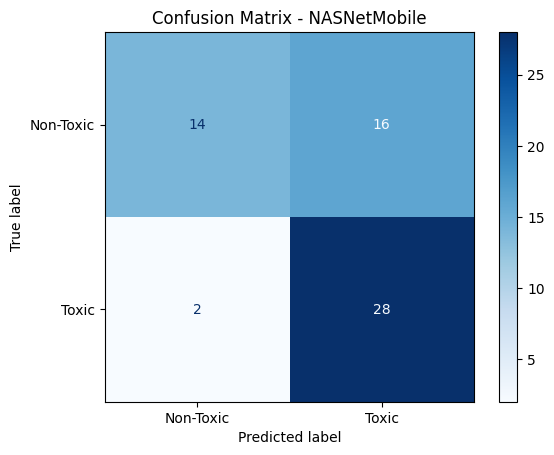

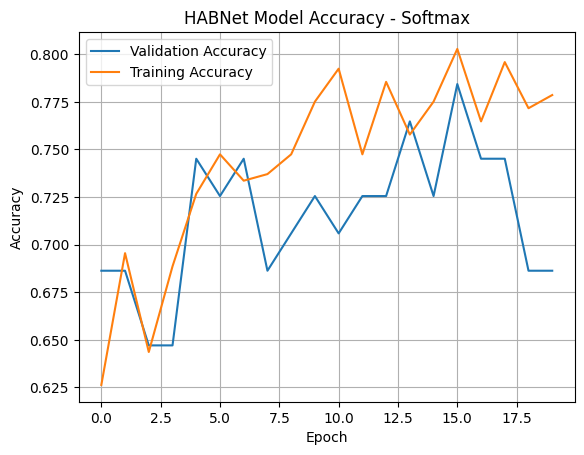

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


In [53]:
model_nasnet = train_pretrained_model(NASNetMobile, "NASNetMobile")
preds = np.argmax(model_nasnet.predict(X_test_rgb), axis = 1)
models['NasNet'] = np.round(accuracy_score(y_test, preds), 2)
del model_nasnet

In [54]:
import pandas as pd
df = pd.DataFrame(list(models.items()), columns=['Model', 'Accuracy'])
df

,Model,Accuracy
0,Logistic Regression,0.92
1,Ridge Classifier,0.90
2,XGB Classifier,0.85
3,DT Classifier,0.85
4,RF Classifier,0.88
5,HABnet Sigmoid,0.87
6,HABnet Softmax,0.88
7,EfficientNet,0.50
8,MobileNet,0.77
9,VGGG16,0.75


In [55]:
models

# {'Logistic Regression': 0.92,
#  'Ridge Classifier': 0.9,
#  'XGB Classifier': 0.85,
#  'DT Classifier': 0.83,
#  'RF Classifier': 0.87,
#  'HABnet Sigmoid': 0.92,
#  'HABnet Softmax': 0.9,
#  'EfficientNet': 0.5,
#  'MobileNet': 0.75,
#  'VGGG16': 0.75,
#  'VGG19': 0.72,
#  'ResNet': 0.5,
#  'NasNet': 0.68}

{'Logistic Regression': 0.92,
 'Ridge Classifier': 0.9,
 'XGB Classifier': 0.85,
 'DT Classifier': 0.85,
 'RF Classifier': 0.88,
 'HABnet Sigmoid': 0.87,
 'HABnet Softmax': 0.88,
 'EfficientNet': 0.5,
 'MobileNet': 0.77,
 'VGGG16': 0.75,
 'VGG19': 0.73,
 'ResNet': 0.73,
 'NasNet': 0.7}

# Gibberish

In [ ]:
# X_all_flat = X.reshape(len(X), -1)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_all_flat)

In [ ]:
# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_scaled)
# sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm')
# plt.title("PCA Visualization")
# plt.show()

In [ ]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)
# sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm')
# plt.title("t-SNE Visualization")
# plt.show()

In [ ]:
# explainer = shap.Explainer(xgb)
# shap_values = explainer(X_test_flat[:100])
# shap.summary_plot(shap_values, X_test_flat[:100], feature_names=[f'f{i}' for i in range(X_test_flat.shape[1])])